In [6]:
# download data
! wget https://www.dropbox.com/s/seshsi92ui05crb/kz.csv.zip?dl=0 -O kz.csv.zip
! unzip kz.csv.zip

--2021-05-28 11:38:52--  https://www.dropbox.com/s/seshsi92ui05crb/kz.csv.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/seshsi92ui05crb/kz.csv.zip [following]
--2021-05-28 11:38:52--  https://www.dropbox.com/s/raw/seshsi92ui05crb/kz.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ac9382c99b9540c1eb5840d0d.dl.dropboxusercontent.com/cd/0/inline/BPV6jOPcv0hV6_3EpCIBhtckMtD6n3qgHd2-ODKanpvO4roqQGwBFBML5j8q-ODLwNOOEB1Xa_VIEk13iEisvk0DFKD_ONkRCWTC4J5v2FJPOAetzJuKVyi2maaDrcAfa5Z5rDJe1O_yLZGFVIYLscBo/file# [following]
--2021-05-28 11:38:53--  https://uc9ac9382c99b9540c1eb5840d0d.dl.dropboxusercontent.com/cd/0/inline/BPV6jOPcv0hV6_3EpCIBhtckMtD6n3qgHd2-ODKanpvO4roqQGwBFBML5j8q-ODLwNOOEB1Xa_VIEk13iEisvk0D

In [7]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from scipy.linalg import svd
import plotly.express as px
import plotly.graph_objs as go

%matplotlib inline

In [8]:
df = pd.read_csv('kz.csv')

In [9]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


In [10]:
df.shape

(2633521, 8)

# Data Analisys

In [13]:
counter = 0
for i in range(0, df.shape[0]):
  if np.sum(df.iloc[i].isnull().sum()) == 0:
    counter+=1

'counter = 0\nfor i in range(0, df.shape[0]):\n  if np.sum(df.iloc[i].isnull().sum()) == 0:\n    counter+=1'

In [ ]:
counter #количество полных записей

In [ ]:
df['category'] = df['category_code'].str.rsplit('.', n=1, expand=True)[1]
df.drop(columns=['category_code'], inplace=True)

In [ ]:
pop_cat = df.groupby('category')['price'].agg('count').reset_index().sort_values('price', ascending=False).head(15)
pop_cat.rename(columns={"category": "category", "price": "times_sold"}, inplace=True)

In [ ]:
fig = px.bar(
    pop_cat, 
    x='category', 
    y='times_sold', 
    width=1200, 
    height=800
)

fig.show()

In [ ]:
value_brands = df.groupby('brand')['price'].sum().reset_index().sort_values('price', ascending=False).head(15)

In [ ]:
fig = px.bar(
    value_brands, 
    x='brand', 
    y='price', 
    width=1200, 
    height=800
)

fig.show()

In [ ]:
popular_brand = df.groupby('brand')['price'].agg('count').reset_index().sort_values('price', ascending=False).head(15)
popular_brand.rename(columns={"brand": "brand", "price": "times_sold"}, inplace=True)

In [ ]:
fig = px.bar(
    popular_brand, 
    x='brand', 
    y='times_sold', 
    width=1200, 
    height=800
)

fig.show()

# Preprocessing

In [14]:
# oставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.
users_interactions_count_df = (
    df
    .groupby(['user_id', 'product_id'])
    .first()
    .reset_index()
    .groupby('user_id').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 98262
# users with at least 5 interactions: 17704


In [15]:
# oставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.
interactions_from_selected_users_df = df.loc[np.in1d(df.user_id,
            users_with_enough_interactions_df)]

In [16]:
interactions_from_selected_users_df

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18
5,2020-04-26 08:45:57 UTC,2295716521449619559,1515966223509261697,2.268105e+18,furniture.kitchen.table,maestro,39.33,1.515916e+18
6,2020-04-26 09:33:47 UTC,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18
7,2020-04-26 09:33:47 UTC,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18
8,2020-04-26 09:33:47 UTC,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18
...,...,...,...,...,...,...,...,...
2633504,2020-11-21 09:59:55 UTC,2388440981134693931,2388434452473986696,2.268105e+18,appliances.environment.air_heater,ava,43.96,1.515916e+18
2633508,2020-11-21 10:02:06 UTC,2388440981134693935,2273948303068496095,2.268105e+18,electronics.smartphone,huawei,185.16,1.515916e+18
2633512,2020-11-21 10:06:01 UTC,2388440981134693939,1515966223509090132,2.268105e+18,computers.peripherals.printer,canon,299.98,1.515916e+18
2633514,2020-11-21 10:08:54 UTC,2388440981134693941,1515966223519279912,2.374499e+18,electronics.video.tv,samsung,1736.09,1.515916e+18


In [17]:
# oбъединяем все взаимодействия пользователя по каждому товару в одно
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['user_id', 'product_id']).sum()
    .reset_index().set_index(['user_id', 'product_id'])
)
interactions_full_df['last_timestep'] = (
    interactions_from_selected_users_df
    .groupby(['user_id', 'product_id'])['event_time'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,user_id,product_id,order_id,category_id,price,last_timestep
0,1.515916e+18,1515966223509104210,2.388441e+18,2.374499e+18,115.72,2020-10-23 03:51:26 UTC
1,1.515916e+18,1515966223509122863,2.388441e+18,2.268105e+18,1504.61,2020-11-16 15:49:50 UTC
2,1.515916e+18,1515966223522710798,2.388441e+18,2.268105e+18,138.87,2020-11-16 15:49:50 UTC
3,1.515916e+18,2273948310777627555,2.388441e+18,2.268105e+18,335.63,2020-11-16 15:49:50 UTC
4,1.515916e+18,2309018185069757002,2.388441e+18,2.268105e+18,40.81,2020-10-21 12:23:18 UTC


In [18]:
interactions_full_df.shape

(334725, 6)

In [19]:
# перевел в формат datetime и отсортировал
interactions_full_df['last_timestep'] = interactions_full_df['last_timestep'].apply(lambda x:datetime.timestamp(datetime.strptime(x, '%Y-%m-%d %H:%M:%S %Z')))
interactions_full_df = interactions_full_df.sort_values('last_timestep').reset_index(drop=True)

In [20]:
interactions_full_df

,user_id,product_id,order_id,category_id,price,last_timestep
0,1.515916e+18,1515966223509090236,2.340103e+18,2.268105e+18,18.50,2.020000e+03
1,1.515916e+18,2273948186349404174,2.348533e+18,2.268105e+18,30.07,2.020000e+03
2,1.515916e+18,2273948180989083750,2.348533e+18,2.268105e+18,7.38,2.020000e+03
3,1.515916e+18,1515966223510673543,2.348533e+18,2.268105e+18,43.96,2.020000e+03
4,1.515916e+18,1515966223510225741,2.348533e+18,2.268105e+18,4.61,2.020000e+03
...,...,...,...,...,...,...
334720,1.515916e+18,2388434452473986696,2.388441e+18,2.268105e+18,43.96,1.605953e+09
334721,1.515916e+18,2273948303068496095,4.776882e+18,4.536211e+18,370.32,1.605953e+09
334722,1.515916e+18,1515966223509090132,2.388441e+18,2.268105e+18,299.98,1.605953e+09
334723,1.515916e+18,1515966223519279912,2.388441e+18,2.374499e+18,1736.09,1.605953e+09


In [21]:
# pазобьём выборку на обучение и контроль по времени в соотношении 75/25
split_ts = int(interactions_full_df.iloc[int(interactions_full_df.shape[0]*0.75)]['last_timestep'])
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestep < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestep >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 251042
# interactions on Test set: 83683


,user_id,product_id,order_id,category_id,price,last_timestep
0,1.515916e+18,1515966223509090236,2.340103e+18,2.268105e+18,18.50,2.020000e+03
1,1.515916e+18,2273948186349404174,2.348533e+18,2.268105e+18,30.07,2.020000e+03
2,1.515916e+18,2273948180989083750,2.348533e+18,2.268105e+18,7.38,2.020000e+03
3,1.515916e+18,1515966223510673543,2.348533e+18,2.268105e+18,43.96,2.020000e+03
4,1.515916e+18,1515966223510225741,2.348533e+18,2.268105e+18,4.61,2.020000e+03
...,...,...,...,...,...,...
251037,1.515916e+18,2273948219627012463,2.388441e+18,2.268105e+18,42.80,1.602936e+09
251038,1.515916e+18,2273948226161738588,7.165323e+18,6.804316e+18,4.11,1.602936e+09
251039,1.515916e+18,1515966223509353956,2.388441e+18,2.268105e+18,6.69,1.602936e+09
251040,1.515916e+18,1515966223509257795,2.388441e+18,2.268105e+18,462.94,1.602936e+09


In [22]:
interactions_full_df.iloc[251041]

user_id          1.515916e+18
product_id       1.515966e+18
order_id         2.388441e+18
category_id      2.268105e+18
price            6.711000e+01
last_timestep    1.602936e+09
Name: 251041, dtype: float64

In [13]:
interactions = (
    interactions_train_df
    .groupby('user_id')['product_id'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'product_id': 'true_train'})
    .set_index('user_id')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('user_id')['product_id'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
user_id,,
1.515916e+18,"[1515966223509352229, 1515966223509089059, 151...","[1515966223509104974, 2309018188450366314, 227..."


In [14]:
interactions_full_df.groupby('product_id').count().sort_values('order_id').iloc[-1]

user_id          943
order_id         943
category_id      943
price            943
last_timestep    943
Name: 1515966223509088613, dtype: int64

In [15]:
df[df.product_id==1515966223509088613] #наиболее популярный товар

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
34,2020-04-29 10:46:21 UTC,2297951447913857849,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
49,2020-04-29 12:25:34 UTC,2298001389550305634,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
409,2020-04-30 05:48:22 UTC,2298526250039247566,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
440,2020-04-30 06:32:26 UTC,2298548426389848086,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
496,2020-04-30 07:58:52 UTC,2298591932353347813,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
...,...,...,...,...,...,...,...,...
2630782,2020-11-19 10:03:31 UTC,2388440981134692171,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
2630987,2020-11-19 11:58:01 UTC,2388440981134692268,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
2632086,2020-11-19 07:10:36 UTC,2388440981134692867,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18
2633366,2020-11-21 06:53:56 UTC,2388440981134693814,1515966223509088613,2.268105e+18,electronics.audio.headphone,apple,203.68,1.515916e+18


# Main part

## Base model (модель выдающая самые популярные товары)

In [16]:
# сортируем по популярности
popular_content = (
    interactions_train_df
    .groupby('product_id')
    .user_id.count().reset_index()
    .product_id.values
)

In [17]:
popular_content

array([1515966223509088493, 1515966223509088496, 1515966223509088497, ...,
       2388434452475855948, 2388434452475855949, 2388434452475855950])

In [25]:
print(df.loc[df.product_id == popular_content[0]][['category_code','brand']]) #самый популярный товар

                  category_code  brand
1062     electronics.smartphone  apple
5171     electronics.smartphone  apple
5411     electronics.smartphone  apple
5642     electronics.smartphone  apple
5897     electronics.smartphone  apple
...                         ...    ...
2623072  electronics.smartphone  apple
2623327  electronics.smartphone  apple
2632629  electronics.smartphone  apple
2632637  electronics.smartphone  apple
2632876  electronics.smartphone  apple

[1440 rows x 2 columns]


In [26]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

In [42]:
# подсчет precision@10
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [28]:
calc_precision('prediction_popular')

0.0005860024419242492

In [43]:
# финансовый плюс@10
price_dict = pd.DataFrame({'price':interactions_full_df.groupby('product_id').mean()['price']}, 
                          index=interactions_full_df.groupby('product_id').mean().index).to_dict()

def proceeds(column):
    res = []
    for i in interactions.apply(lambda row:
            set(row['true_test']).intersection(set(row[column])), axis=1):
        res.extend(i)
    return sum([price_dict['price'][i] for i in res])

In [117]:
proceeds('prediction_popular') #выигрыш в денежном вырадении

13148.054013656954

In [118]:
proceeds('prediction_popular')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.20893908690180757

## Memory-based collaborative filtering

In [16]:
interactions_train_df['eventStrength']=np.ones(interactions_train_df.shape[0])

In [17]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='user_id',
    columns='product_id').fillna(0)

In [18]:
ratings_m = ratings.values

In [25]:
# матрица корреляций
similarity_users = np.corrcoef(ratings_m)

In [27]:
prediction_user_based = []
for i in tqdm(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))
interactions['prediction_user_based'] = prediction_user_based

In [28]:
calc_precision('prediction_user_based')

0.0036360613333033106

In [29]:
proceeds('prediction_user_based') #выигрыш в денежном вырадении

68480.28497087724

In [30]:
proceeds('prediction_user_based')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

1.0882377116589765

## Модель разложения со скрытыми переменными

In [19]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(17238, 17171) (17238, 17238) (17171,) (17171, 17171)


In [27]:
# K наиболее важных компонент
K = 400
sigma[K:] = 0
Sigma = np.zeros((17238, 17171))
Sigma[:17171, :17171] = np.diag(sigma)

In [28]:
new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

128591.15027110193
250829.08301499774


In [31]:
top_k = 10

new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []
for user_id in tqdm(interactions.index):
    prediction = (
        new_ratings
        .loc[user_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[user_id, 'true_train'])])[:top_k])
interactions['prediction_svd'] = predictions

In [35]:
calc_precision('prediction_svd')

0.003869806707793473

In [36]:
proceeds('prediction_svd') #выигрыш в денежном вырадении

33022.86034778828

In [37]:
proceeds('prediction_svd')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.5247747142494218

## Factorization Machines

In [65]:
!pip install git+https://github.com/coreylynch/pyFM

  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-fdn9947u
  Running command git clone -q https://github.com/coreylynch/pyFM /tmp/pip-req-build-fdn9947u
  Created wheel for pyfm: filename=pyfm-0.0.0-cp37-cp37m-linux_x86_64.whl size=216597 sha256=4b82f70482107614cc83d72db4f740bfb8d8e8f402332b7409fa8abf1fa8a33a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8q0ikjr/wheels/3b/d9/ef/1b148c527d39344632833679e79b3db1798a40b0f64f917b13
Successfully built pyfm


In [66]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

In [67]:
train_dataset_fm = []

for i in tqdm(range(0, interactions_train_df.shape[0])):
    user = interactions_train_df.iloc[i]['user_id'].astype(int)
    item = interactions_train_df.iloc[i]['product_id'].astype(int)
    train_dataset_fm += [{'user': str(user), 'item': str(item)}]
y_train = np.ones(interactions_train_df.shape[0])

In [68]:
train_dataset_fm[:5]

[{'item': '1515966223509090304', 'user': '1515915625479406080'},
 {'item': '2273948186349404160', 'user': '1515915625484433920'},
 {'item': '2273948180989083648', 'user': '1515915625484433920'},
 {'item': '1515966223510673664', 'user': '1515915625484433920'},
 {'item': '1515966223510225664', 'user': '1515915625484433920'}]

In [69]:
v = DictVectorizer()
X_train = v.fit_transform(train_dataset_fm)
y_train = np.array(y_train)

In [70]:
%%time
fm = pylibfm.FM(num_factors=32, num_iter=20, verbose=True, task="classification", 
                initial_learning_rate=0.01, learning_rate_schedule="optimal")
fm.fit(X_train, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training log loss: 0.00330
-- Epoch 2
Training log loss: 0.00028
-- Epoch 3
Training log loss: 0.00016
-- Epoch 4
Training log loss: 0.00012
-- Epoch 5
Training log loss: 0.00009
-- Epoch 6
Training log loss: 0.00007
-- Epoch 7
Training log loss: 0.00006
-- Epoch 8
Training log loss: 0.00005
-- Epoch 9
Training log loss: 0.00005
-- Epoch 10
Training log loss: 0.00004
-- Epoch 11
Training log loss: 0.00004
-- Epoch 12
Training log loss: 0.00003
-- Epoch 13
Training log loss: 0.00003
-- Epoch 14
Training log loss: 0.00003
-- Epoch 15
Training log loss: 0.00003
-- Epoch 16
Training log loss: 0.00003
-- Epoch 17
Training log loss: 0.00002
-- Epoch 18
Training log loss: 0.00002
-- Epoch 19
Training log loss: 0.00002
-- Epoch 20
Training log loss: 0.00002
CPU times: user 3min 44s, sys: 1.45 s, total: 3min 45s
Wall time: 3min 43s


In [71]:
test_dataset_fm = []

for i in tqdm(range(0, interactions_test_df.shape[0])):
    user = interactions_test_df.iloc[i]['user_id'].astype(int)
    item = interactions_test_df.iloc[i]['product_id'].astype(int)
    test_dataset_fm += [{'user': str(user), 'item': str(item)}]
y_test = np.ones(interactions_test_df.shape[0])

In [72]:
X_test = v.transform(test_dataset_fm)
y_test = np.array(y_test)

In [74]:
products = interactions_full_df.product_id.unique()
predictionsss = []
for user in tqdm(interactions.index):
    X_test_dict = []
    for item in products:
        X_test_dict += [{'user': str(user), 'item': str(item)}]
    X_test = v.transform(X_test_dict)
    pred = fm.predict(X_test)
    test = pd.DataFrame({'product_id':products, 'prediction':pred})
    predictionsss.append(test.sort_values('prediction', ascending=False)['product_id'][:10])
    
interactions['prediction_fm'] = predictionsss

In [75]:
calc_precision('prediction_fm')

8.801826662361938e-05

In [76]:
proceeds('prediction_fm') #выигрыш в денежном вырадении

1123.1032051282052

In [77]:
proceeds('prediction_fm')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.017847520091736613

## Другая модель FM

In [16]:
!pip install lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset

In [17]:
data = Dataset()
data.fit(interactions_full_df.user_id.astype(int).unique(), interactions_full_df.product_id.astype(int).unique())
interactions_train_matrix, data_train = data.build_interactions([tuple(i) for i in interactions_train_df[['user_id', 'product_id']].astype(int).values])
interactions_test_matrix, data_test = data.build_interactions([tuple(i) for i in interactions_test_df[['user_id', 'product_id']].astype(int).values])

In [18]:
len_users = len(interactions_full_df.user_id.unique())
len_items = len(interactions_full_df.product_id.unique())
users_test = (np.ones((len_items,len_users))*np.arange(0,len_users)).T.reshape(len_items*len_users)
items_test = (np.ones((len_items,len_users)).T*np.arange(0,len_items)).reshape(len_items*len_users)

In [19]:
users_test

array([    0.,     0.,     0., ..., 17703., 17703., 17703.])

In [20]:
lfm = LightFM(loss='warp')
lfm.fit(interactions_train_matrix, sample_weight = data_train)
pred = lfm.predict(users_test, items_test)

In [21]:
userss = {v: k for k, v in data.mapping()[0].items()}
itemss = {v: k for k, v in data.mapping()[2].items()}

In [22]:
fin_pred = pred.reshape((len_users,len_items)).argsort()[::-1][:,:10]

In [24]:
fin_pred.shape

(17704, 10)

In [34]:
fin_pred[4]

array([18525,  4428, 17393, 11540, 17336, 18648, 18816,  9176, 18001,
       18232])

In [29]:
len(userss.values())

17704

In [33]:
userss.items()

dict_items([(0, 1515915625479406080), (1, 1515915625484433920), (2, 1515915625442736640), (3, 1515915625479406336), (4, 1515915625479774464), (5, 1515915625442537472), (6, 1515915625442592768), (7, 1515915625452108288), (8, 1515915625451564544), (9, 1515915625484433664), (10, 1515915625484433408), (11, 1515915625463906048), (12, 1515915625442052608), (13, 1515915625454125824), (14, 1515915625478103040), (15, 1515915625453674752), (16, 1515915625453651200), (17, 1515915625511663104), (18, 1515915625476772352), (19, 1515915625476351232), (20, 1515915625456580608), (21, 1515915625455680256), (22, 1515915625441905920), (23, 1515915625466711808), (24, 1515915625441945856), (25, 1515915625441947136), (26, 1515915625441953536), (27, 1515915625463751168), (28, 1515915625511158016), (29, 1515915625479405824), (30, 1515915625470467328), (31, 1515915625485935360), (32, 1515915625441031680), (33, 1515915625462877952), (34, 1515915625462858752), (35, 1515915625441055488), (36, 1515915625469160448),

In [39]:
top_k = 10

tmp_predictions = []

for (n, personId) in tqdm(userss.items()):
    if personId in interactions.index:
      prediction = np.asarray([itemss[i] for i in fin_pred[n]])
      
      tmp_predictions.append(
          list(prediction[~np.in1d(
              prediction,
              interactions.loc[personId, 'true_train'])])[:top_k])

    
interactions['prediction_content'] = tmp_predictions

In [44]:
calc_precision('prediction_content')

3.4387646666087006e-05

In [47]:
proceeds('prediction_content') #выигрыш в денежном вырадении

183.94533333333334

In [48]:
proceeds('prediction_content')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.0029231223074224024

# Модели на 50 предсказаний

## Base model (модель выдающая самые популярные товары)

In [17]:
# сортируем по популярности
popular_content = (
    interactions_train_df
    .groupby('product_id')
    .user_id.count().reset_index()
    .product_id.values
)

In [18]:
top_k = 50

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

In [81]:
# подсчет precision@50
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 50.0),
            axis=1)).mean()

In [20]:
calc_precision('prediction_popular')

0.00664422910858329

In [82]:
# финансовый плюс@50
price_dict = pd.DataFrame({'price':interactions_full_df.groupby('product_id').mean()['price']}, 
                          index=interactions_full_df.groupby('product_id').mean().index).to_dict()

def proceeds(column):
    res = []
    for i in interactions.apply(lambda row:
            set(row['true_test']).intersection(set(row[column])), axis=1):
        res.extend(i)
    return sum([price_dict['price'][i] for i in res])

In [22]:
proceeds('prediction_popular') #выигрыш в денежном вырадении

251192.68625825358

In [23]:
proceeds('prediction_popular')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

3.99176718080838

## Memory-based collaborative filtering

In [24]:
interactions_train_df['eventStrength']=np.ones(interactions_train_df.shape[0])

In [25]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='user_id',
    columns='product_id').fillna(0)

In [26]:
ratings_m = ratings.values

In [27]:
# матрица корреляций
similarity_users = np.corrcoef(ratings_m)

In [28]:
prediction_user_based = []
for i in tqdm(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:50]
        prediction_user_based.append(list(recommend))
interactions['prediction_user_based'] = prediction_user_based

In [29]:
calc_precision('prediction_user_based')

0.013309346379243307

In [30]:
proceeds('prediction_user_based') #выигрыш в денежном вырадении

311622.83492096135

In [31]:
proceeds('prediction_user_based')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

4.952078118823369

## Модель разложения со скрытыми переменными

In [32]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(17238, 17171) (17238, 17238) (17171,) (17171, 17171)


In [33]:
# K наиболее важных компонент
K = 400
sigma[K:] = 0
Sigma = np.zeros((17238, 17171))
Sigma[:17171, :17171] = np.diag(sigma)

In [34]:
new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

128591.15027110193
250829.08301499774


In [35]:
top_k = 50

new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []
for user_id in tqdm(interactions.index):
    prediction = (
        new_ratings
        .loc[user_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[user_id, 'true_train'])])[:top_k])
interactions['prediction_svd'] = predictions

In [36]:
calc_precision('prediction_svd')

0.00895510917378739

In [37]:
proceeds('prediction_svd') #выигрыш в денежном вырадении

105037.58617962904

In [38]:
proceeds('prediction_svd')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

1.669179129013747

## FM

In [80]:
products = interactions_full_df.product_id.unique()
predictionsss = []
for user in tqdm(interactions.index):
    X_test_dict = []
    for item in products:
        X_test_dict += [{'user': str(user), 'item': str(item)}]
    X_test = v.transform(X_test_dict)
    pred = fm.predict(X_test)
    test = pd.DataFrame({'product_id':products, 'prediction':pred})
    predictionsss.append(test.sort_values('prediction', ascending=False)['product_id'][:50])
    
interactions['prediction_fm'] = predictionsss

In [83]:
calc_precision('prediction_fm')

0.0005532867581376957

In [84]:
proceeds('prediction_fm') #выигрыш в денежном вырадении

4942.543994700953

In [85]:
proceeds('prediction_fm')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.07854322990703934

## Light FM

In [49]:
fin_pred = pred.reshape((len_users,len_items)).argsort()[::-1][:,:50]

In [51]:
top_k = 50

tmp_predictions = []

for (n, personId) in tqdm(userss.items()):
    if personId in interactions.index:
      prediction = np.asarray([itemss[i] for i in fin_pred[n]])
      
      tmp_predictions.append(
          list(prediction[~np.in1d(
              prediction,
              interactions.loc[personId, 'true_train'])])[:top_k])

    
interactions['prediction_content'] = tmp_predictions

In [52]:
calc_precision('prediction_content')

0.0005451221333909937

In [53]:
proceeds('prediction_content') #выигрыш в денежном вырадении

7901.519660256409

In [54]:
proceeds('prediction_content')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.12556506850639787

# Модели на 100 предсказаний

## Base model (модель выдающая самые популярные товары)

In [15]:
# сортируем по популярности
popular_content = (
    interactions_train_df
    .groupby('product_id')
    .user_id.count().reset_index()
    .product_id.values
)

In [16]:
top_k = 100

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

In [86]:
# подсчет precision@100
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 100.0),
            axis=1)).mean()

In [18]:
calc_precision('prediction_popular')

0.012376897860019581

In [87]:
# финансовый плюс@50
price_dict = pd.DataFrame({'price':interactions_full_df.groupby('product_id').mean()['price']}, 
                          index=interactions_full_df.groupby('product_id').mean().index).to_dict()

def proceeds(column):
    res = []
    for i in interactions.apply(lambda row:
            set(row['true_test']).intersection(set(row[column])), axis=1):
        res.extend(i)
    return sum([price_dict['price'][i] for i in res])

In [20]:
proceeds('prediction_popular') #выигрыш в денежном вырадении

438791.21562375437

In [21]:
proceeds('prediction_popular')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

6.972943360114906

## Memory-based collaborative filtering

In [22]:
interactions_train_df['eventStrength']=np.ones(interactions_train_df.shape[0])

In [23]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='user_id',
    columns='product_id').fillna(0)

In [24]:
ratings_m = ratings.values

In [25]:
# матрица корреляций
similarity_users = np.corrcoef(ratings_m)

In [26]:
prediction_user_based = []
for i in tqdm(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:100]
        prediction_user_based.append(list(recommend))
interactions['prediction_user_based'] = prediction_user_based

In [27]:
calc_precision('prediction_user_based')

0.02075173199921388

In [28]:
proceeds('prediction_user_based') #выигрыш в денежном вырадении

488517.82455295936

In [29]:
proceeds('prediction_user_based')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

7.763161612458515

## Модель разложения со скрытыми переменными

In [30]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(17238, 17171) (17238, 17238) (17171,) (17171, 17171)


In [31]:
# K наиболее важных компонент
K = 400
sigma[K:] = 0
Sigma = np.zeros((17238, 17171))
Sigma[:17171, :17171] = np.diag(sigma)

In [32]:
new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

128591.15027110193
250829.08301499774


In [33]:
top_k = 100

new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []
for user_id in tqdm(interactions.index):
    prediction = (
        new_ratings
        .loc[user_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[user_id, 'true_train'])])[:top_k])
interactions['prediction_svd'] = predictions

In [34]:
calc_precision('prediction_svd')

0.01368590581891613

In [35]:
proceeds('prediction_svd') #выигрыш в денежном вырадении

193032.38747064144

In [36]:
proceeds('prediction_svd')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

3.067527007319765

## FM

In [88]:
products = interactions_full_df.product_id.unique()
predictionsss = []
for user in tqdm(interactions.index):
    X_test_dict = []
    for item in products:
        X_test_dict += [{'user': str(user), 'item': str(item)}]
    X_test = v.transform(X_test_dict)
    pred = fm.predict(X_test)
    test = pd.DataFrame({'product_id':products, 'prediction':pred})
    predictionsss.append(test.sort_values('prediction', ascending=False)['product_id'][:100])
    
interactions['prediction_fm'] = predictionsss

In [89]:
calc_precision('prediction_fm')

0.001148866568598332

In [90]:
proceeds('prediction_fm') #выигрыш в денежном вырадении

16867.062547922236

In [91]:
proceeds('prediction_fm')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.2680388020780835

## Light FM

In [55]:
fin_pred = pred.reshape((len_users,len_items)).argsort()[::-1][:,:100]

In [56]:
top_k = 100

tmp_predictions = []

for (n, personId) in tqdm(userss.items()):
    if personId in interactions.index:
      prediction = np.asarray([itemss[i] for i in fin_pred[n]])
      
      tmp_predictions.append(
          list(prediction[~np.in1d(
              prediction,
              interactions.loc[personId, 'true_train'])])[:top_k])

    
interactions['prediction_content'] = tmp_predictions

In [57]:
calc_precision('prediction_content')

0.0010883984537172085

In [58]:
proceeds('prediction_content') #выигрыш в денежном вырадении

28146.00963696448

In [59]:
proceeds('prediction_content')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.44727543310731877

# Модели на 25 предсказаний

## Base model (модель выдающая самые популярные товары)

In [15]:
# сортируем по популярности
popular_content = (
    interactions_train_df
    .groupby('product_id')
    .user_id.count().reset_index()
    .product_id.values
)

In [16]:
top_k = 25

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

In [92]:
# подсчет precision@100
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 25.0),
            axis=1)).mean()

In [18]:
calc_precision('prediction_popular')

0.0024559706355812803

In [93]:
# финансовый плюс@50
price_dict = pd.DataFrame({'price':interactions_full_df.groupby('product_id').mean()['price']}, 
                          index=interactions_full_df.groupby('product_id').mean().index).to_dict()

def proceeds(column):
    res = []
    for i in interactions.apply(lambda row:
            set(row['true_test']).intersection(set(row[column])), axis=1):
        res.extend(i)
    return sum([price_dict['price'][i] for i in res])

In [20]:
proceeds('prediction_popular') #выигрыш в денежном вырадении

77918.2274051107

In [21]:
proceeds('prediction_popular')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

1.2382184671679122

## Memory-based collaborative filtering

In [27]:
interactions_train_df['eventStrength']=np.ones(interactions_train_df.shape[0])

In [28]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='user_id',
    columns='product_id').fillna(0)

In [29]:
ratings_m = ratings.values

In [47]:
# матрица корреляций
similarity_users = np.corrcoef(ratings_m)

In [48]:
prediction_user_based = []
for i in tqdm(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:25]
        prediction_user_based.append(list(recommend))
interactions['prediction_user_based'] = prediction_user_based

In [49]:
calc_precision('prediction_user_based')

0.007665108387843075

In [50]:
proceeds('prediction_user_based') #выигрыш в денежном вырадении

187477.24884838736

In [51]:
proceeds('prediction_user_based')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

2.979248879610439

## Модель разложения со скрытыми переменными

In [30]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(17238, 17171) (17238, 17238) (17171,) (17171, 17171)


In [31]:
# K наиболее важных компонент
K = 400
sigma[K:] = 0
Sigma = np.zeros((17238, 17171))
Sigma[:17171, :17171] = np.diag(sigma)

In [32]:
new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

128591.15027110193
250829.08301499774


In [33]:
top_k = 25

new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []
for user_id in tqdm(interactions.index):
    prediction = (
        new_ratings
        .loc[user_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[user_id, 'true_train'])])[:top_k])
interactions['prediction_svd'] = predictions

In [34]:
calc_precision('prediction_svd')

0.0060969330331789645

In [35]:
proceeds('prediction_svd') #выигрыш в денежном вырадении

63971.8797937698

In [36]:
proceeds('prediction_svd')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

1.016593492665826

## FM

In [94]:
products = interactions_full_df.product_id.unique()
predictionsss = []
for user in tqdm(interactions.index):
    X_test_dict = []
    for item in products:
        X_test_dict += [{'user': str(user), 'item': str(item)}]
    X_test = v.transform(X_test_dict)
    pred = fm.predict(X_test)
    test = pd.DataFrame({'product_id':products, 'prediction':pred})
    predictionsss.append(test.sort_values('prediction', ascending=False)['product_id'][:25])
    
interactions['prediction_fm'] = predictionsss

In [95]:
calc_precision('prediction_fm')

0.00028061267831054555

In [96]:
proceeds('prediction_fm') #выигрыш в денежном вырадении

3727.3492327961876

In [97]:
proceeds('prediction_fm')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.05923225934846755

## Light FM

In [60]:
fin_pred = pred.reshape((len_users,len_items)).argsort()[::-1][:,:25]

In [61]:
top_k = 25

tmp_predictions = []

for (n, personId) in tqdm(userss.items()):
    if personId in interactions.index:
      prediction = np.asarray([itemss[i] for i in fin_pred[n]])
      
      tmp_predictions.append(
          list(prediction[~np.in1d(
              prediction,
              interactions.loc[personId, 'true_train'])])[:top_k])

    
interactions['prediction_content'] = tmp_predictions

In [62]:
calc_precision('prediction_content')

0.00010028533181060694

In [63]:
proceeds('prediction_content') #выигрыш в денежном вырадении

842.1030256410255

In [64]:
proceeds('prediction_content')/proceeds('true_test')*100 # выигрыш в процентном выражении относительно выручки теста

0.01338207441739492

# Result analisys

In [ ]:
# prec
k = [10, 25, 50, 100]
base = [0.0005860024419242492, 0.0024559706355812803, 0.00664422910858329, 0.012376897860019581]
Item_based = [0.0036360613333033106, 0.007665108387843075, 0.013309346379243307, 0.02075173199921388]
Svd = [0.003869806707793473, 0.0060969330331789645, 0.00895510917378739, 0.01368590581891613]
pyfm = [8.801826662361938e-05, 0.00028061267831054555, 0.0005532867581376957, 0.001148866568598332]
lightfm = [3.4387646666087006e-05, 0.00010028533181060694, 0.0005451221333909937, 0.0010883984537172085]

Text(0, 0.5, 'precision@k score')

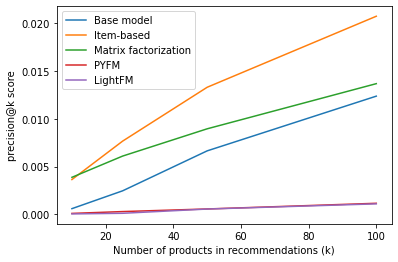

In [ ]:
plt.plot(k,base,k,Item_based,k,Svd,k,pyfm,k,lightfm)
plt.legend(['Base model', 'Item-based', 'Matrix factorization', 'PYFM', 'LightFM'])
plt.xlabel('Number of products in recommendations (k)')
plt.ylabel('precision@k score')

In [ ]:
# proceeds
k = [10, 25, 50, 100]
base = [13148.054013656954, 77918.2274051107, 251192.68625825358, 438791.21562375437]
Item_based = [68480.28497087724, 187477.24884838736, 311622.83492096135, 488517.82455295936]
Svd = [33022.86034778828, 63971.8797937698, 105037.58617962904, 193032.38747064144]
pyfm = [1123.1032051282052, 3727.3492327961876, 4942.543994700953, 16867.062547922236]
lightfm = [183.94533333333334, 842.1030256410255, 7901.519660256409, 28146.00963696448]

Text(0, 0.5, 'Revenue from recommendations in thousands of c.u.')

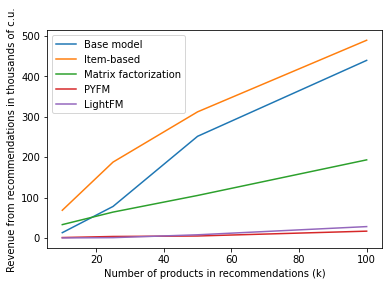

In [ ]:
plt.plot(k,np.array(base)/1000,k,np.array(Item_based)/1000,k,np.array(Svd)/1000,k,np.array(pyfm)/1000,k,np.array(lightfm)/1000)
plt.legend(['Base model', 'Item-based', 'Matrix factorization', 'PYFM', 'LightFM'])
plt.xlabel('Number of products in recommendations (k)')
plt.ylabel('Revenue from recommendations in thousands of c.u.')

In [ ]:
# proceeds in %
k = [10, 25, 50, 100]
base = [0.20893908690180757, 1.2382184671679122, 3.99176718080838, 6.972943360114906]
Item_based = [1.0882377116589765, 2.979248879610439, 4.952078118823369, 7.763161612458515]
Svd = [0.5247747142494218, 1.016593492665826, 1.669179129013747, 3.067527007319765]
pyfm = [0.017847520091736613, 0.05923225934846755, 0.07854322990703934, 0.2680388020780835]
lightfm = [0.0029231223074224024, 0.01338207441739492, 0.12556506850639787, 0.44727543310731877]

Text(0, 0.5, 'Revenue from recommendations / total revenue (%)')

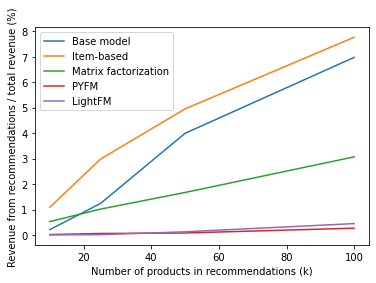

In [ ]:
plt.plot(k,base,k,Item_based,k,Svd,k,pyfm,k,lightfm)
plt.legend(['Base model', 'Item-based', 'Matrix factorization', 'PYFM', 'LightFM'])
plt.xlabel('Number of products in recommendations (k)')
plt.ylabel('Revenue from recommendations / total revenue (%)')